In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 1323
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.vistanet import *
from utils.train import *
from typing import *
from collections import Counter

from utils.load_yelp import *
from utils.dataset import *
from utils.train import *

In [2]:
config = default_config
config

{'task': 'CLS',
 'embedding_dim': 200,
 'embedding': None,
 'freeze_embedding': False,
 'word_hidden_size': 50,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 50,
 'sentence_layers': 1,
 'img_input_size': 4096,
 'visual_attention_size': 100,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0}

In [3]:
train_set, valid_set, test_set= load_glove_vgg_data(split811data, config)

In [4]:
batch_size = 128
workers = 6
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 9128805, 'Trainable': 9128805}, CrossEntropyLoss())

In [7]:
# viz = get_Visdom()

# lr = 1e-3
# epoches = 20
# optimizer = get_regal_optimizer(model, optim.AdamW, lr)
# k_batch_train_visdom(model, optimizer, loss, valid_loader, viz, 20, 10)

In [5]:
%%time
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

CPU times: user 3.58 s, sys: 745 ms, total: 4.32 s
Wall time: 5.03 s


((0.20564334085778782, 0.1434817099075212),
 Counter({3: 2225, 2: 1903, 4: 299, 0: 3}))

In [6]:
%%time
_interval = 5
lr = 1e-3
epoches = 50
stoping_step = 5
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)
text_writer = VisdomTextWriter(viz, "Training")

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom_v2(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer, text_writer,
                         _interval=_interval, early_stop=stoping_step)

Setting up a new session...
No 1 epoch: 277it [01:56,  2.37it/s]
No 2 epoch: 277it [01:55,  2.39it/s]
No 3 epoch: 277it [01:56,  2.39it/s]
No 4 epoch: 277it [01:57,  2.37it/s]
No 5 epoch: 277it [01:56,  2.38it/s]
No 6 epoch: 277it [01:56,  2.38it/s]
No 7 epoch: 277it [01:57,  2.35it/s]
No 8 epoch: 277it [01:56,  2.38it/s]
No 9 epoch: 277it [01:57,  2.36it/s]


CPU times: user 16min 42s, sys: 1min 29s, total: 18min 11s
Wall time: 18min 17s


In [7]:
res

{'min_valid_loss': 0.9119880300074076,
 'min_valid_loss_epoch': 4,
 'min_loss_train_acc': 0.49290449992946817,
 'min_valid_loss_train_loss': 1.0839026130226137,
 'min_loss_valid_acc': 0.6137697516930023,
 'last_valid_acc': 0.5715575620767495,
 'last_train_acc': 0.622852306390182,
 'last_epoch': 9,
 'last_train_loss': 0.7673639008349433,
 'last_valid_loss': 1.1665909093335842}

In [8]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.6069977426636569, 0.6091158044781914), 0.9016356048142667)

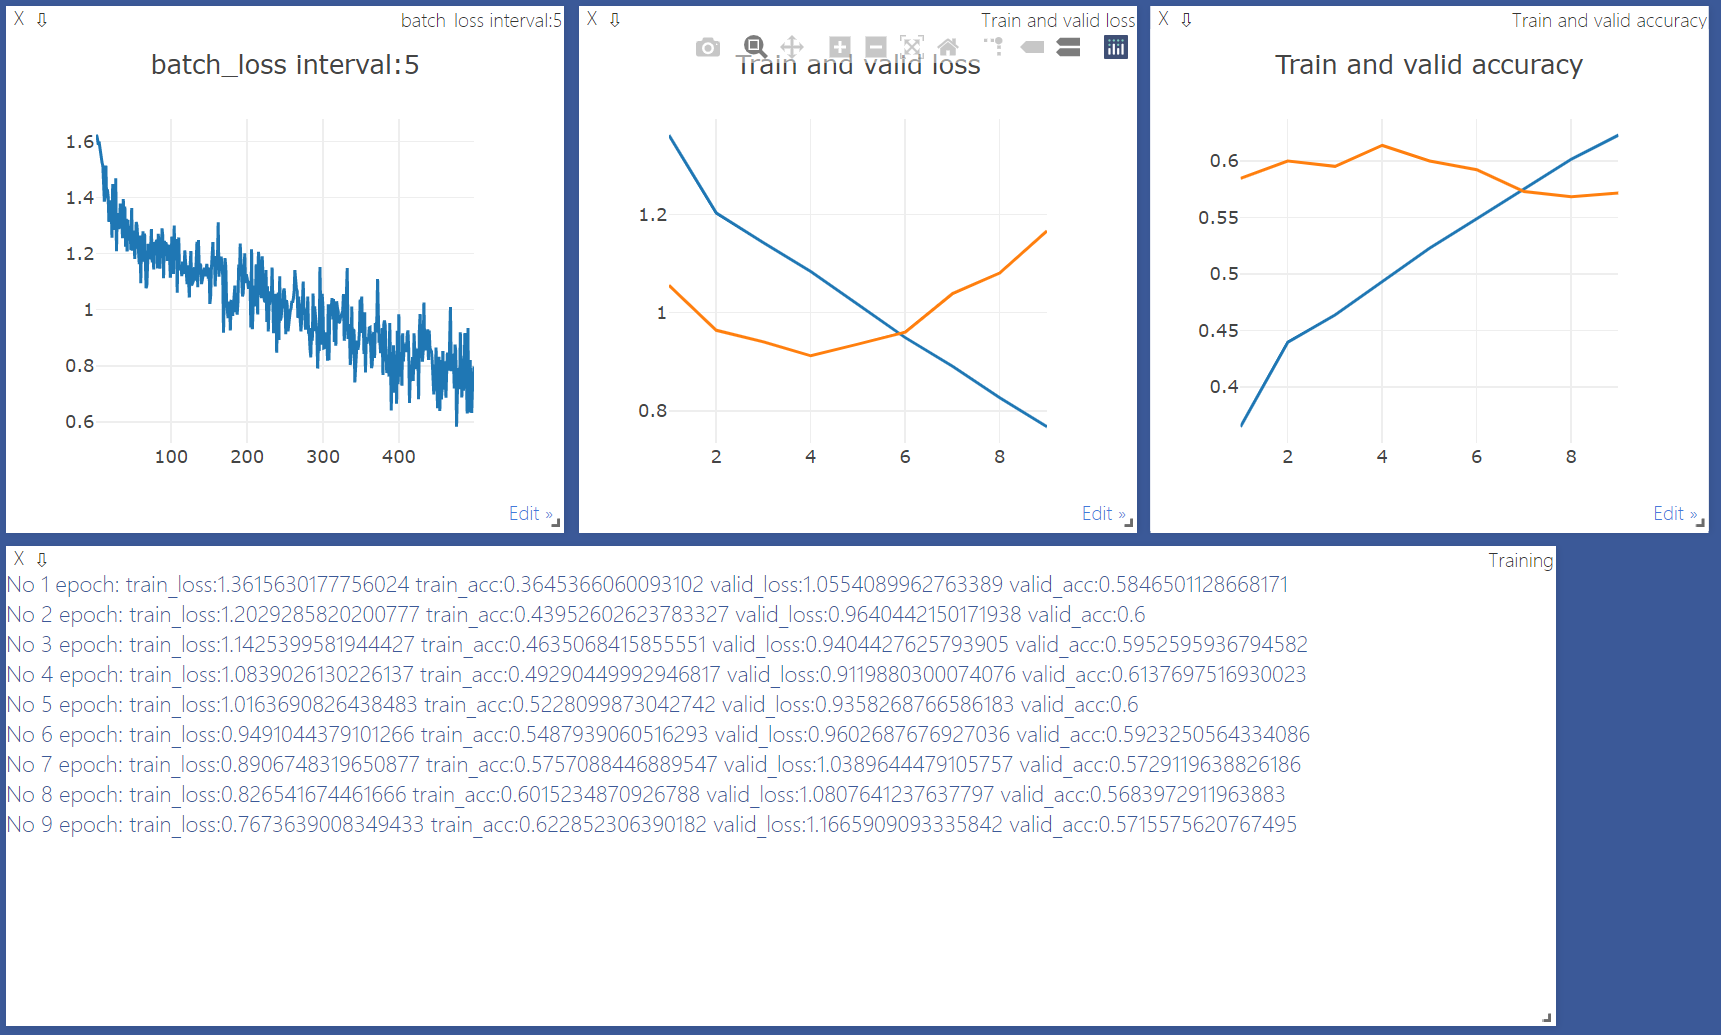